# MNIST Classification with EffAxNet 2D

This notebook demonstrates training the EffAxNet 2D model on the MNIST dataset for handwritten digit classification.

## Environment Setup

Import necessary libraries and verify TensorFlow installation.

In [17]:
import tensorflow as tf
from tensorflow import keras
from syntropy.tf.models import EffAxNetV1
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## Load and Prepare MNIST Dataset

Load MNIST data, normalize pixel values, and convert grayscale to RGB (EffAxNet expects 3-channel input).

In [18]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Original image shape: {x_train.shape[1:]}")

Training samples: 60000
Test samples: 10000
Original image shape: (28, 28)


In [ ]:
# Preprocess: normalize
def preprocess_mnist(images):
    # Normalize to [0, 1]
    images = images.astype('float32') / 255.0
    # Add channel dimension: (28, 28) -> (28, 28, 1)
    images = np.expand_dims(images, axis=-1)
    return images

x_train_processed = preprocess_mnist(x_train)
x_test_processed = preprocess_mnist(x_test)

print(f"Processed training shape: {x_train_processed.shape}")
print(f"Processed test shape: {x_test_processed.shape}")

Processed training shape: (60000, 28, 28, 1)
Processed test shape: (10000, 28, 28, 1)


## Visualize Sample Images

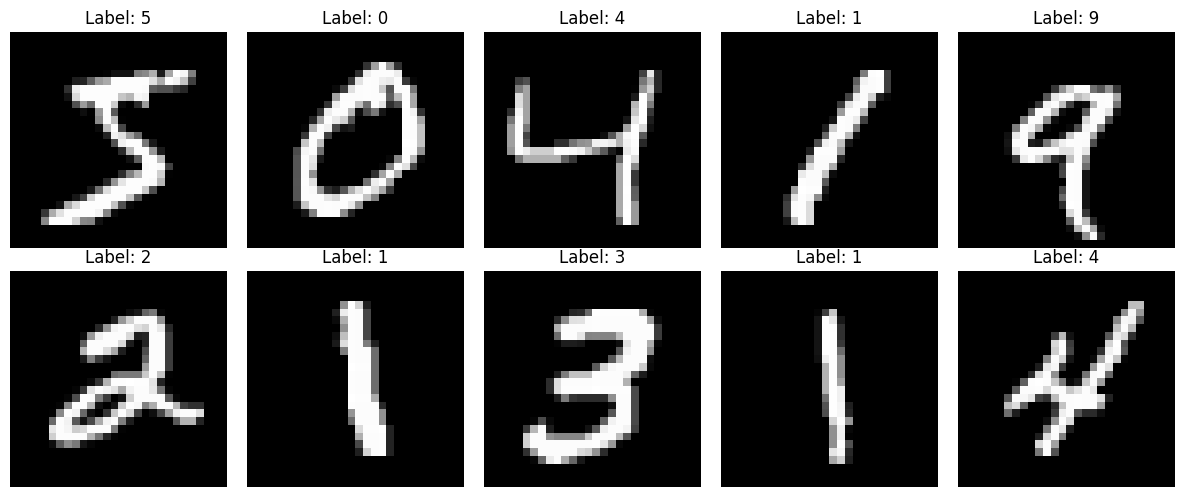

In [20]:
# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # Show original size image (before resizing)
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Build EffAxNet Model with Classification Head

Create the EffAxNet backbone and add a custom classification head for 10 MNIST classes.

In [24]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create EffAxNet backbone (feature extractor)
backbone = EffAxNetV1(
    variant="2d",
    include_top=False,
    pooling="avg",
    input_shape=(28, 28, 1),
)

print(f"Backbone output shape: {backbone.output_shape}")

Backbone output shape: (None, 256)


In [25]:
# Build complete model with classification head
inputs = backbone.input
x = keras.layers.Dense(128, activation="relu", name="dense1")(backbone.output)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(10, activation="softmax", name="output")(x)

model = keras.Model(inputs, outputs, name="effaxnet_mnist")

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary(line_length=110)

Model: "effaxnet_mnist"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, 28, 28, 1)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_conv (Conv2D)                             │ (None, 7, 7, 32)                    │                 512 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_bn (BatchNormalization)                   │ (None, 7, 7, 32)                    │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_activation (Activation)                   │ (None, 7, 7, 32)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage1_dw (DepthwiseConv2D)                    │ (None, 7, 7, 32)                    │                 288 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage1_dw_bn (BatchNormalization)              │ (None, 7, 7, 32)                    │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage1_dw_act (Activation)                     │ (None, 7, 7, 32)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage1_pw (Conv2D)                             │ (None, 7, 7, 48)                    │               1,536 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage1_pw_bn (BatchNormalization)              │ (None, 7, 7, 48)                    │                 192 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage1_pw_act (Activation)                     │ (None, 7, 7, 48)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ channel_attn_1 (ChannelAttention2D)            │ (None, 7, 7, 48)                    │                 288 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ pool_1 (MaxPooling2D)                          │ (None, 4, 4, 48)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage2_dw (DepthwiseConv2D)                    │ (None, 4, 4, 48)                    │                 432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage2_dw_bn (BatchNormalization)              │ (None, 4, 4, 48)                    │                 192 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage2_dw_act (Activation)                     │ (None, 4, 4, 48)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage2_pw (Conv2D)                             │ (None, 4, 4, 64)                    │               3,072 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stage2_pw_bn (BatchNormalization)              │ (None, 4, 4, 64)                    │                 256 │
├───

 Total params: 179,258 (700.23 KB)

 Trainable params: 177,658 (693.98 KB)

 Non-trainable params: 1,600 (6.25 KB)

## Train the Model

Train with frozen backbone first.

In [27]:
# Training callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    x_train_processed,
    y_train,
    batch_size=32,
    epochs=1,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9544 - loss: 0.1601 - val_accuracy: 0.9697 - val_loss: 0.1044 - learning_rate: 0.0010


## Plot Training History

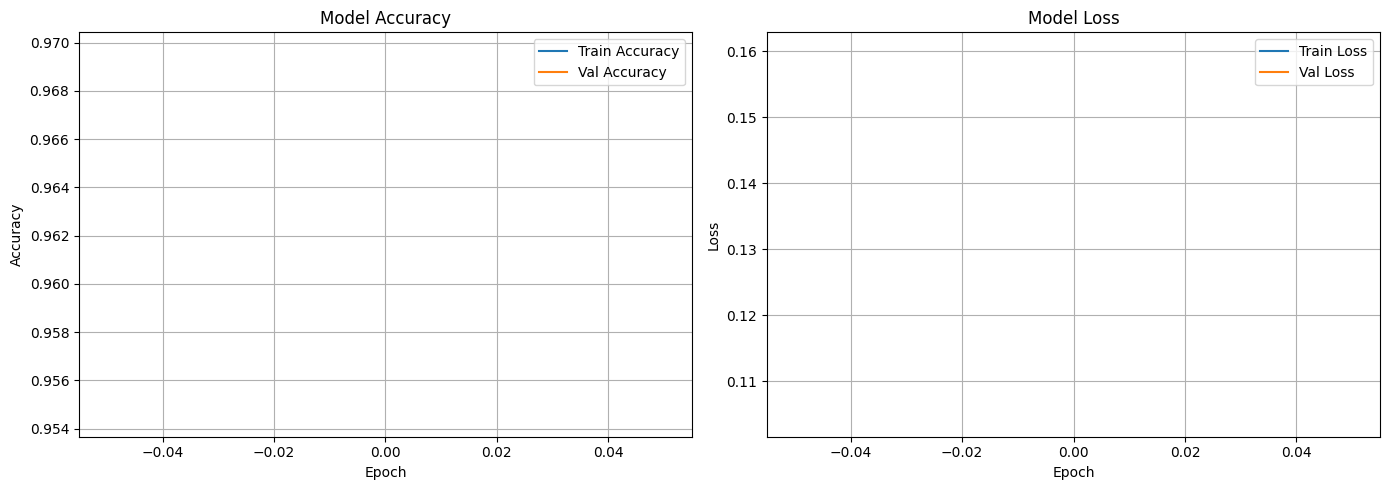

In [28]:
# Plot training & validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [29]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(x_test_processed, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9659 - loss: 0.1101

Test Accuracy: 96.59%
Test Loss: 0.1101


## Make Predictions and Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


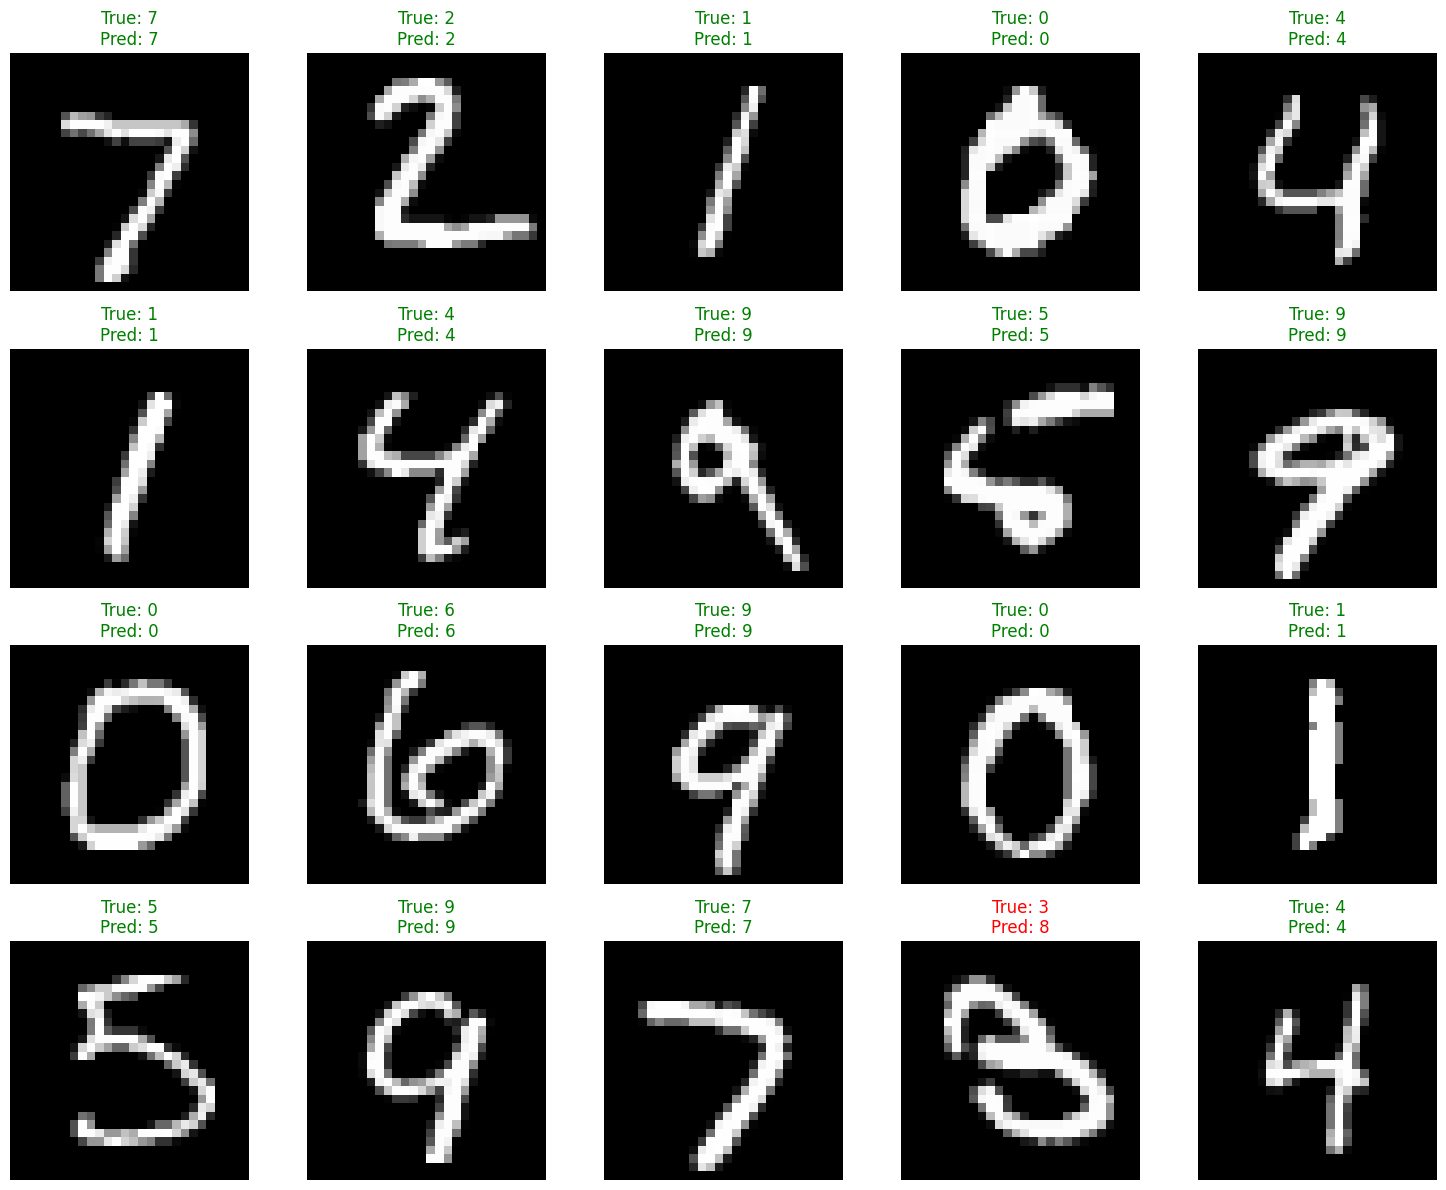

In [30]:
# Make predictions on test set
predictions = model.predict(x_test_processed[:20])
predicted_classes = np.argmax(predictions, axis=1)

# Visualize predictions
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i], cmap='gray')
    color = 'green' if predicted_classes[i] == y_test[i] else 'red'
    ax.set_title(f"True: {y_test[i]}\nPred: {predicted_classes[i]}", color=color)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Optional: Fine-Tuning

Unfreeze the backbone and fine-tune with a lower learning rate.

In [32]:
# Unfreeze backbone for fine-tuning
backbone.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("Model ready for fine-tuning with unfrozen backbone.")

# Fine-tune for a few more epochs
history_finetune = model.fit(
    x_train_processed,
    y_train,
    batch_size=32,
    epochs=1,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Model ready for fine-tuning with unfrozen backbone.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.9684 - loss: 0.1078 - val_accuracy: 0.9785 - val_loss: 0.0726 - learning_rate: 1.0000e-05


## Final Evaluation After Fine-Tuning

In [33]:
# Final evaluation
final_test_loss, final_test_accuracy = model.evaluate(x_test_processed, y_test, verbose=1)
print(f"\nFinal Test Accuracy: {final_test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9773 - loss: 0.0723

Final Test Accuracy: 97.73%
Final Test Loss: 0.0723


## Save the Model

In [34]:
# Save the trained model
model.save('effaxnet_mnist_model.keras')
print("Model saved as 'effaxnet_mnist_model.keras'")

Model saved as 'effaxnet_mnist_model.keras'
